In [238]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [67]:
# Global Variables

ratedCap = 8 #MW
costPerMW = 0.9 #£1.1mil per MW
initElecPrice = 5 #£/mwh 
capFactor = 0.3 #Output is 30% of RC
availability = 0.95 #Assume turbines are on 95% of the time
numberOfTurbines=100

inflationRate = 1.05
riskAdjRate = 0.07 #risk-adjusted discount rate
riskFreeRate = 0.03

assetLife = 20
gearBoxLife = 10



impCostGearbox = 100 # millions

In [18]:
# Legacy Function Definitions

def findSetupCost(ratedCap, numberOfTurbines, costPerMW):
    setupCost = numberOfTurbines * costPerMW * ratedCap
    return setupCost

def netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability):
    grossYield = numberOfTurbines * ratedCap * capFactor * 8760 #8760 hours in a year
    netYield = availability * grossYield
    return netYield

#assetLife, initElecPrice, inflationRate,riskAdjRate,numberOfTurbines
def cashFlowCalculation(*args):
    discountedCashFlows = np.zeros(assetLife)

    
    for i in range(0,assetLife):
        netYield = netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability)
        discountedCashFlows[i] = pow(10,-6)* 0.7 * np.random.normal(initElecPrice,3) * pow(inflationRate,i) * netYield / pow((1 + riskAdjRate), i)
        
    return discountedCashFlows


#assetLife, initElecPrice, inflationRate,riskAdjRate,numberOfTurbines
def baseCashFlowCalculation(*args):
    discountedBaseCashFlows = np.zeros(assetLife)

    
    
    for i in range(0,assetLife):
        netYield = netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability)
        discountedBaseCashFlows[i] = pow(10,-6)* 0.7 * initElecPrice * pow(inflationRate,i) * netYield / pow((1 + riskAdjRate), i)
        
    return discountedBaseCashFlows

In [19]:
# Simulation Environment Functions

def TurbineDeathSimulation(scale, loc):
    """Takes the baseCashFlows and simulates how turbine failures would change overall project npv"""
    
    discountedBaseCashFlows = baseCashFlowCalculation()
    x= np.floor(np.random.normal(loc = loc , scale = scale , size = numberOfTurbines)).astype('int')
    unique, counts = np.unique(x, return_counts=True)
    y = np.asarray((unique, 1 - np.cumsum(counts)/numberOfTurbines)).T

    if np.any(y<0):
        y = np.asarray([ [ i[0]-min(y[:,0]) , i[1] ] for i in y ])
        
        if np.any(y>assetLife-1):
            y = y[y[:,0] < assetLife]
            y[-1][1] = 0

    elif np.any(y>assetLife-1):
        y = np.asarray([ [ i[0] - ( max(y[:,0]) - (assetLife-1) ) , i[1] ] for i in y ]) 

        if np.any(y<0):
            startValue = y[0][1]
            y = y[y[:,0] > -1]
            y[0][1] = startValue
            
            
    
    probArray = np.ones(assetLife)
    for count,i in enumerate(y):
        probArray[i[0].astype('int')] = i[1]
    probArray = [0 if count>y[-1][0] else i for count,i in enumerate(probArray)]    
    
    output = discountedBaseCashFlows * probArray
    
    return output[output > 0]
    

    
    
def SigmaCalculator(testFunction,arguments):
    """Takes the price fluctuated cash flows and calculates the mean of the standard deviation of the
    logrithemic returns ,from it"""
    
    sigma_array = []
    for _ in range(0,10000):
        
        discountedCashFlows = testFunction(arguments)
        logrithmicReturns = np.zeros(len(discountedCashFlows) - 1)
        
        for g in enumerate(discountedCashFlows):
            if g[0]<len(discountedCashFlows) - 1:
                logrithmicReturns[g[0]] = np.log( discountedCashFlows[g[0]+1]/discountedCashFlows[g[0]] )

        sigma_array.append(np.std(logrithmicReturns))

    sigma = np.mean(sigma_array)
    return sigma
       
  

In [20]:
# Option Valuation Functions
def GearboxVal(tree , steps , p , delta , assetLife , impCostGearbox):
    """ Gives us the npv of the gear box replacement option applied """   

    count = 0
    optionTree = np.copy(tree)

    for i in range(0,steps):
            gain = ( pow(inflationRate,assetLife+gearBoxLife) - 1 ) / ( pow(inflationRate,assetLife) - 1 )
            case0 = (optionTree[i,steps-1] * gain) - impCostGearbox
            optionTree[i,steps-1] = max(optionTree[i,steps-1] ,case0 )

    for i in range(steps-1, 0 ,-1):
        for j in range(0,steps-1):

            case1 = ( p*optionTree[j , i] + (1-p)*optionTree[j+1 , i] ) * np.exp(-1* riskFreeRate * delta)

            extraYears = max(np.floor(delta*i) + gearBoxLife - assetLife , 0) 
            gain = ( pow(inflationRate,assetLife+extraYears) - 1 ) / ( pow(inflationRate,assetLife) - 1 ) 

            case2 = (optionTree[j , i-1] * gain) - impCostGearbox

            optionTree[j , i-1] = max(case1 , case2)    



    return optionTree




def AbandonmentVal(optionTree , steps , p , delta , abdValue):
    """ Gives us the npv of the Abandonment option applied """

    option_values = np.copy(optionTree)

    for i in range(0,steps):
        option_values[i , steps-1] = max( option_values[i , steps-1] , abdValue )

    for i in range(steps-1, 0 ,-1):
        for j in range(0,steps-1):
            case1 = ( p*option_values[j , i] + (1-p)*option_values[j+1 , i] ) * np.exp(-1* riskFreeRate * delta)
            case2 = (option_values[j , i -1] / option_values[j , i -1] ) * abdValue

            option_values[j , i -1 ] = max(case1 , case2)


    return option_values    
        

                                      
                                      
                                      
def InitCalc(cashFlows ,steps , impCostGearbox , abdValue):
    """ Brings together all the other option calculations """
    sigma2 = 0.085
    S0 = sum(cashFlows)
    assetLife = len(cashFlows)
    delta = assetLife / steps
    u = np.exp(sigma2 * np.sqrt(delta)) 
    d = 1/u
    p = ( np.exp(riskFreeRate * delta) - d ) / (u - d)
    tree = np.zeros((steps, steps))
    

    #Tree Initial Seeding  
    for i in range(0,steps):
        tree[0 , i] = S0 * pow(u,i)  


    #Tree Propagator     
    for i in range(0,steps-1):
        if i < steps-1:
            for j in range(0,steps):
                if j < steps-1:
                    tree[i+1 , j+1] = tree[i,j] * d
    tree[tree == 0] = None

    
    
    
    optionTree = GearboxVal(tree , steps , p , delta , assetLife , impCostGearbox) 
    AoptionTree = AbandonmentVal(optionTree , steps , p , delta , abdValue)
    
    return tree , optionTree , AoptionTree




In [233]:
# Testing single failure scenario trees
initElecPrice = 20

#sigma = SigmaCalculator(cashFlowCalculation,())
tree,optionTree,AoptionTree = InitCalc(TurbineDeathSimulation(scale = 1,loc = 10) ,steps = 31 , impCostGearbox = 1000000 , abdValue = 500)
#optionTree[0,0] - tree[0,0] # For option value
#pd.DataFrame(tree) # Base tree depending on failure scenario
#pd.DataFrame(optionTree) # Base tree depending on failure scenario , with gearbox replacement option applied
#pd.DataFrame(AoptionTree) # Base tree depending on failure scenario , with gearbox replacement + Abandonment option applied

In [234]:

European_option_value = AoptionTree[0,0]-tree[0,0]
setupCost = findSetupCost(ratedCap, numberOfTurbines, costPerMW)
European_project_value = European_option_value - setupCost
print(tree[0,0])
print(tree[0,0]-setupCost)
print(European_option_value)
print(European_project_value)

244.31092547355198
-475.68907452644805
255.68907452644802
-464.31092547355195


In [228]:
pd.DataFrame(optionTree)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,677.219331,717.006438,758.989444,803.288012,850.028313,899.343372,951.373443,1006.266403,1064.178164,1125.273112,...,2180.328628,2302.577405,2431.510106,2567.490245,2710.901085,2862.146707,3021.653145,3189.869573,3367.269570,3554.352437
1,NaN,637.875252,675.560809,715.328543,757.291950,801.570691,848.290932,897.585697,949.595237,1004.467427,...,1952.453502,2062.326858,2178.212056,2300.436109,2429.343799,2565.298634,2708.683875,2859.903599,3019.383835,3187.573757
2,NaN,NaN,600.505708,636.197357,673.863315,713.611221,755.554569,799.813016,846.512727,895.786721,...,1747.449661,1846.189688,1950.336929,2060.185562,2176.045748,2298.244498,2427.126588,2563.055526,2706.414566,2857.607782
3,NaN,NaN,NaN,565.008380,598.808214,634.480035,672.125934,711.853547,753.776363,798.014040,...,1563.021570,1651.745694,1745.333089,1844.048393,1948.170622,2057.993951,2173.828538,2296.001389,2424.857279,2560.759709
4,NaN,NaN,NaN,NaN,531.286215,563.291059,597.070833,632.722361,670.347728,710.054571,...,1397.104088,1476.817581,1560.904997,1649.604398,1743.166781,1841.856782,1945.953412,2055.750843,2171.559229,2293.705573
5,NaN,NaN,NaN,NaN,NaN,499.247151,529.548834,561.533384,595.292628,630.923385,...,1247.839350,1319.446588,1394.987515,1474.676285,1558.738690,1647.412787,1740.949571,1839.613673,1943.684102,2053.455026
6,NaN,NaN,NaN,NaN,NaN,NaN,468.803859,497.489476,527.770629,559.734408,...,1113.555959,1177.870548,1245.722777,1317.305292,1392.821208,1472.484674,1556.521479,1645.169678,1738.680262,1837.317857
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.873503,467.025653,495.690500,...,992.750274,1050.504159,1111.439386,1175.729252,1243.556470,1315.113681,1390.603998,1470.241566,1554.252170,1642.873862
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412.377507,438.074527,...,884.069568,935.921232,990.633701,1048.362863,1109.273079,1173.537641,1241.339259,1312.870573,1388.334688,1467.945749
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,386.241333,...,786.296887,832.838721,881.952995,933.779936,988.467394,1046.171252,1107.055869,1171.294533,1239.069950,1310.574756


In [229]:
pd.DataFrame(AoptionTree)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,679.526769,718.348425,759.737351,803.684297,850.226036,899.435164,951.412494,1006.281325,1064.183148,1125.274510,...,2180.328628,2302.577405,2431.510106,2567.490245,2710.901085,2862.146707,3021.653145,3189.869573,3367.269570,3554.352437
1,NaN,641.680788,677.822375,716.619386,757.994075,801.931179,848.463569,897.661649,949.625326,1004.477870,...,1952.453502,2062.326858,2178.212056,2300.436109,2429.343799,2565.298634,2708.683875,2859.903599,3019.383835,3187.573757
2,NaN,NaN,606.710381,639.963510,676.064305,714.840153,756.203982,800.133985,846.658868,895.846806,...,1747.449661,1846.189688,1950.336929,2060.185562,2176.045748,2298.244498,2427.126588,2563.055526,2706.414566,2857.607782
3,NaN,NaN,NaN,575.007846,605.003780,638.185833,674.249582,713.008678,754.365805,798.291990,...,1563.021570,1651.745694,1745.333089,1844.048393,1948.170622,2057.993951,2173.828538,2296.001389,2424.857279,2560.759709
4,NaN,NaN,NaN,NaN,547.214557,573.357125,603.229476,636.343323,672.374938,711.122863,...,1397.104088,1476.817581,1560.904997,1649.604398,1743.166781,1841.856782,1945.953412,2055.750843,2171.559229,2293.705573
5,NaN,NaN,NaN,NaN,NaN,524.327637,545.699172,571.632481,601.381177,634.430882,...,1247.839350,1319.446588,1394.987515,1474.676285,1558.738690,1647.412787,1740.949571,1839.613673,1943.684102,2053.455026
6,NaN,NaN,NaN,NaN,NaN,NaN,507.849705,523.078517,544.107829,569.825675,...,1113.555959,1177.870548,1245.722777,1317.305292,1392.821208,1472.484674,1556.521479,1645.169678,1738.680262,1837.317857
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000,507.071680,521.760436,...,992.750274,1050.504159,1111.439386,1175.729252,1243.556470,1315.113681,1390.603998,1470.241566,1554.252170,1642.873862
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000,500.000000,...,884.069568,935.921232,990.633701,1048.362863,1109.273079,1173.537641,1241.339259,1312.870573,1388.334688,1467.945749
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000,...,786.312556,832.838721,881.952995,933.779936,988.467394,1046.171252,1107.055869,1171.294533,1239.069950,1310.574756


In [230]:
pd.DataFrame(tree)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,309.123258,325.911094,343.610642,362.271416,381.945617,402.688283,424.557440,447.614265,471.923257,497.552420,...,938.530501,989.500125,1043.237803,1099.893861,1159.626791,1222.603692,1289.000735,1359.003664,1432.808304,1510.621120
1,NaN,293.200171,309.123258,325.911094,343.610642,362.271416,381.945617,402.688283,424.557440,447.614265,...,844.332422,890.186346,938.530501,989.500125,1043.237803,1099.893861,1159.626791,1222.603692,1289.000735,1359.003664
2,NaN,NaN,278.097290,293.200171,309.123258,325.911094,343.610642,362.271416,381.945617,402.688283,...,759.588781,800.840456,844.332422,890.186346,938.530501,989.500125,1043.237803,1099.893861,1159.626791,1222.603692
3,NaN,NaN,NaN,263.772366,278.097290,293.200171,309.123258,325.911094,343.610642,362.271416,...,683.350658,720.462000,759.588781,800.840456,844.332422,890.186346,938.530501,989.500125,1043.237803,1099.893861
4,NaN,NaN,NaN,NaN,250.185325,263.772366,278.097290,293.200171,309.123258,325.911094,...,614.764374,648.150939,683.350658,720.462000,759.588781,800.840456,844.332422,890.186346,938.530501,989.500125
5,NaN,NaN,NaN,NaN,NaN,237.298160,250.185325,263.772366,278.097290,293.200171,...,553.061933,583.097568,614.764374,648.150939,683.350658,720.462000,759.588781,800.840456,844.332422,890.186346
6,NaN,NaN,NaN,NaN,NaN,NaN,225.074818,237.298160,250.185325,263.772366,...,497.552420,524.573449,553.061933,583.097568,614.764374,648.150939,683.350658,720.462000,759.588781,800.840456
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.481107,225.074818,237.298160,...,447.614265,471.923257,497.552420,524.573449,553.061933,583.097568,614.764374,648.150939,683.350658,720.462000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.484593,213.481107,...,402.688283,424.557440,447.614265,471.923257,497.552420,524.573449,553.061933,583.097568,614.764374,648.150939
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.054515,...,362.271416,381.945617,402.688283,424.557440,447.614265,471.923257,497.552420,524.573449,553.061933,583.097568


In [ ]:
# Below here is for running the american option
#################################################################################

In [ ]:
###Test American option

initElecPrice = 30
multiTreeOption = []
steps = 31
locVal = np.arange(1, assetLife-1, (assetLife-2) / steps )

for n in range(0,len(locVal)): 

    averageOptionValue=[]

    for _ in range(0,50):    
        tree,optionTree,AoptionTree = InitCalc(TurbineDeathSimulation(scale = 1,loc = locVal[n]) ,steps = 31 , impCostGearbox = 100, abdValue = 500)        
        averageOptionValue.append(AoptionTree[0,0]-tree[0,0])

    multiTreeOption.append( np.mean(averageOptionValue) )

multiTreeOption = np.asarray(multiTreeOption)
print(multiTreeOption)
# ######################
# Estimating mean of standard deviation of logrithmic returns of multiTreeOption

def substitute(multiTreeOption):
    return multiTreeOption
metaSigma = SigmaCalculator(substitute , (multiTreeOption))


print("mean of logrithmic returns standard deviations is: " + str(metaSigma))



# ######################
# Final tree seeding 

delta = assetLife / steps 
u = np.exp(metaSigma * np.sqrt(delta)) 
d = 1/u
p = ( np.exp(riskFreeRate * delta) - d ) / (u - d)
if p > 1:
    p=0.8
print(p)
finalTree = np.zeros((steps, steps))

if multiTreeOption[0] < multiTreeOption[-1]:  # When seeding largest values must be first as that is how BT works
    finalTree[:,-1] = np.fliplr([multiTreeOption])
else:
    finalTree[:,-1] = multiTreeOption

finalTree[finalTree == 0] = None

#back propagation algorithem
for i in range(steps-1, 0 ,-1):
    for j in range(0,steps-1):

        case1 = ( p*finalTree[j , i] + (1-p)*finalTree[j+1 , i] )           
        finalTree[j , i-1] = case1



pd.DataFrame(finalTree)

In [99]:
# Plot multiple values from American option######################
# calculates out option values for different failure situations and stores in multiTreeOption array
plotarr = []
for QQ in range(1,28):
    initElecPrice = QQ * 2
    multiTreeOption = []
    steps = 31
    locVal = np.arange(1, assetLife-1, (assetLife-2) / steps )

    for n in range(0,len(locVal)): 

        averageOptionValue=[]

        for _ in range(0,50):    
            tree,optionTree,AoptionTree = InitCalc(TurbineDeathSimulation(scale = 1,loc = locVal[n]) ,steps = 31 , impCostGearbox = 100, abdValue = 500)        
            averageOptionValue.append(AoptionTree[0,0]-tree[0,0])

        multiTreeOption.append( np.mean(averageOptionValue) )

    multiTreeOption = np.asarray(multiTreeOption)
    print(multiTreeOption)
    # ######################
    # Estimating mean of standard deviation of logrithmic returns of multiTreeOption

    def substitute(multiTreeOption):
        return multiTreeOption
    metaSigma = SigmaCalculator(substitute , (multiTreeOption))


    print("mean of logrithmic returns standard deviations is: " + str(metaSigma))



    # ######################
    # Final tree seeding 

    delta = assetLife / steps 
    u = np.exp(metaSigma * np.sqrt(delta)) 
    d = 1/u
    p = ( np.exp(riskFreeRate * delta) - d ) / (u - d)
    if p > 1:
        p=0.99
    finalTree = np.zeros((steps, steps))

    if multiTreeOption[0] < multiTreeOption[-1]:  # When seeding largest values must be first as that is how BT works
        finalTree[:,-1] = np.fliplr([multiTreeOption])
    else:
        finalTree[:,-1] = multiTreeOption

    finalTree[finalTree == 0] = None

    #back propagation algorithem
    for i in range(steps-1, 0 ,-1):
        for j in range(0,steps-1):

            case1 = ( p*finalTree[j , i] + (1-p)*finalTree[j+1 , i] )           
            finalTree[j , i-1] = case1


    plotarr.append(finalTree[0,0])
    #pd.DataFrame(finalTree)

[492.78969195 493.24267243 493.21158916 493.11372373 492.28341361
 490.69553833 489.24043887 487.69999761 486.20469741 484.74243887
 483.17559665 481.81114472 480.25818808 478.92053731 477.40940789
 475.88245827 474.69428519 473.38857817 472.04580091 470.7340962
 469.42505132 468.11268108 466.76336467 465.53473467 464.40084723
 463.04320896 461.95824546 460.73313573 460.04185556 459.91553905
 460.20125133]
mean of logrithmic returns standard deviations is: 0.0011921226907372106
[485.81155764 486.48940436 485.94511843 485.68334915 484.04319985
 481.36729005 478.32890877 475.1981727  472.20451028 469.51980135
 466.39478518 463.53120721 460.65057638 457.62314922 454.87365215
 452.28179532 449.55789728 446.68388465 444.23783522 441.37909061
 438.85156233 436.19714266 433.75919207 431.27175581 428.55164355
 426.17000375 423.66210452 421.5068576  419.67650928 420.09234822
 419.37837738]
mean of logrithmic returns standard deviations is: 0.002257430220054912
[478.39185633 479.69061549 478.463

[379.83710644 384.26758841 381.37678019 376.7266806  365.75182185
 365.0963367  382.68186271 402.7829757  427.01423722 446.53393176
 466.6577225  484.21623628 502.46309431 518.27616756 535.68397772
 550.37560911 565.97495878 581.09145832 588.2645537  603.96565246
 614.87733848 624.20993317 635.87978321 646.348772   654.91252733
 666.42350413 675.68409791 686.50666024 692.72822714 693.98525222
 688.7720505 ]
mean of logrithmic returns standard deviations is: 0.019709952694027318
[377.95371806 380.9268009  375.44349172 379.5634812  365.33820709
 371.66746684 404.32464454 428.93112179 456.45156177 479.48864915
 496.27975381 518.84909604 529.79484116 559.63098769 569.57830751
 588.71240824 601.67750959 613.09362671 627.12923597 636.7354716
 647.00405015 666.598341   675.32069546 686.95162036 693.20317532
 709.19911051 715.32486679 727.9666326  735.34772829 736.47832425
 735.16172414]
mean of logrithmic returns standard deviations is: 0.023477150617317904
[377.95291005 383.56165623 382.1565

Text(0, 0.5, 'Option value £(Mill)')

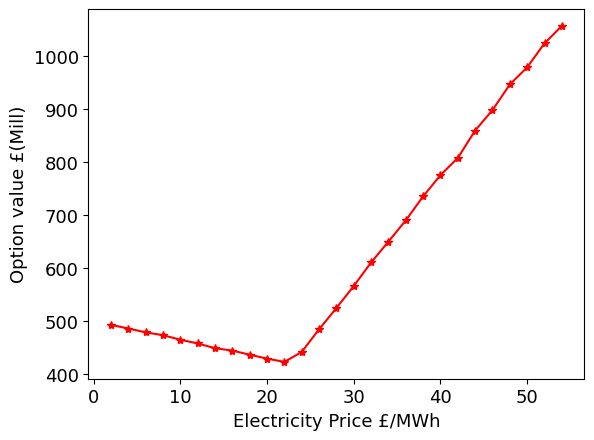

In [240]:
matplotlib.rcParams.update({'font.size': 13})

#matplotlib.rc('font', **font)
plt.plot([i*2 for i in range(1,28)],plotarr,'-*r')
plt.xlabel("Electricity Price £/MWh")
plt.ylabel("Option value £(Mill)")